IMPORTING LIBRARIES

In [1]:
# Data loading and manipulation
import pandas as pd
import numpy as np

# Text preprocessing and NLP
import nltk
import re 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)



# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.colors as pc
from IPython.display import Image, display
from PIL import Image, ImageDraw, ImageFont

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from imblearn.pipeline import Pipeline

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB


# Model evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Model interpretation and saving

import joblib
import pickle


# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set(style="whitegrid")
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


Data Loading and Inspection

In [2]:
#Load the dataset
Movie_df = pd.read_csv('../Data/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')
# Display the first 10 rows of the dataset
Movie_df.head(10)


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [3]:
Movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
Movie_df.shape

(9093, 3)

In [5]:
Movie_df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

Rename columns for clarity 


In [6]:
Movie_df.columns = ['Tweet', 'Item', 'Sentiment']

Movie_df.head(7)

,Tweet,Item,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product


Check for missing values

In [7]:

Movie_df.isna().sum().sort_index(ascending=True)

Item         5802
Sentiment       0
Tweet           1
dtype: int64

Handling Missing Values

In [8]:
# Removing the one row with missing tweet text (can't analyze what doesn't exist)
Movie_df = Movie_df.dropna(subset=['Tweet'])

# For missing products, we'll fill with 'Unknown' rather than dropping
# These tweets still have sentiment and can be valuable for analysis
Movie_df['Item'] = Movie_df['Item'].fillna('Unknown')

print(f"Dataset shape after handling missing values: {Movie_df.shape}")
print(f"\nRemaining missing values:")
print(Movie_df.isnull().sum())

Dataset shape after handling missing values: (9092, 3)

Remaining missing values:
Tweet        0
Item         0
Sentiment    0
dtype: int64


Removing Duplicates

In [9]:
Movie_df = Movie_df.drop_duplicates()
print(f"Dataset shape after removing duplicates: {Movie_df.shape}")

Dataset shape after removing duplicates: (9070, 3)


In [10]:
#recheck if dropped
Movie_df.duplicated().sum()

0

EXPLORATORY DATA ANALYSIS
To better understand our text data, we explore the following questions:

1.Product Engagement:
Which products receive the highest number of reviews or customer interactions?

2.Target Class Distribution:
How are sentiment classes distributed across the dataset, and is there any class imbalance?

3.Text Length vs Sentiment:
Does the number of words or the length of a tweet influence whether the sentiment is positive or negative? In other words, are positive or negative tweets more expressive?

4.Sentiment Drivers (Vocabulary):
What distinguishes positive tweets from negative ones in terms of word usage? Which words are most common in each sentiment class?

5.Feature–Target Relationships:
What relationships exist between extracted text features and the target variable, particularly in terms of correlation and linearity?

1.What products have the most reviews / customer interaction?

In [11]:
product_counts = Movie_df['Item'].value_counts()

# Display top products
product_counts.head(10)


Item
Unknown                            5788
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: count, dtype: int64

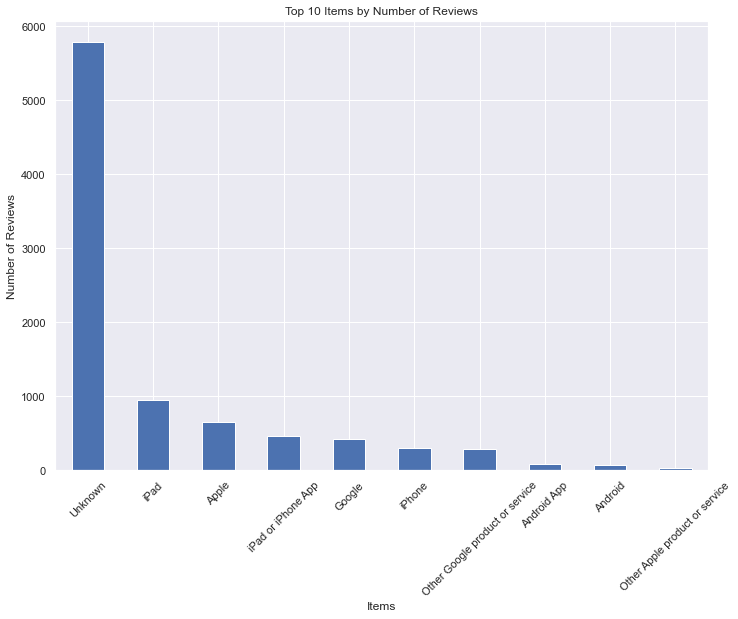

In [12]:
plt.figure()
product_counts.head(10).plot(kind='bar')
plt.title("Top 10 Items by Number of Reviews")
plt.ylabel("Number of Reviews")
plt.xlabel("Items")
plt.xticks(rotation=45)
plt.show()


2.Target class structure and imbalance (sentiment distribution)

In [13]:
sentiment_counts = Movie_df['Sentiment'].value_counts()
sentiment_counts


Sentiment
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64

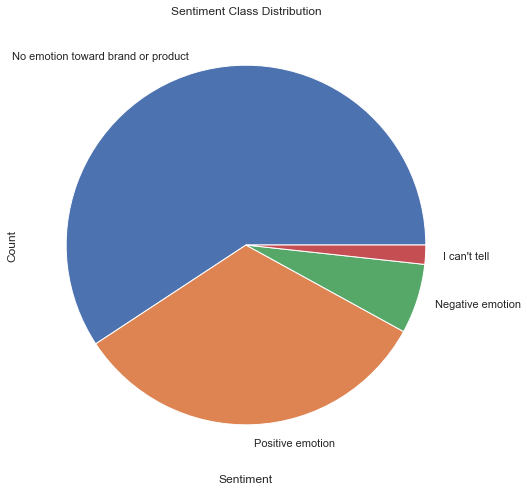

In [14]:
plt.figure()
sentiment_counts.plot(kind='pie')
plt.title("Sentiment Class Distribution")
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.show()


The sentiment classes are noticeably imbalanced, with “no emotion towards brand” representing the largest proportion of the dataset, while “I can’t tell” is the least represented class. To address this, the two categories are combined and treated as a single neutral sentiment, while the remaining classes are retained as positive and negative sentiments.

In [15]:
Movie_df['Sentiment']=Movie_df['Sentiment'].replace({
    "No emotion toward brand or product": "Neutral",
    "I can't tell": "Neutral",
    "Positive emotion": "Positive",
    "Negative emotion" : "Negative"
})

In [16]:
sentiment_counts = Movie_df['Sentiment'].value_counts()
sentiment_counts

Sentiment
Neutral     5531
Positive    2970
Negative     569
Name: count, dtype: int64

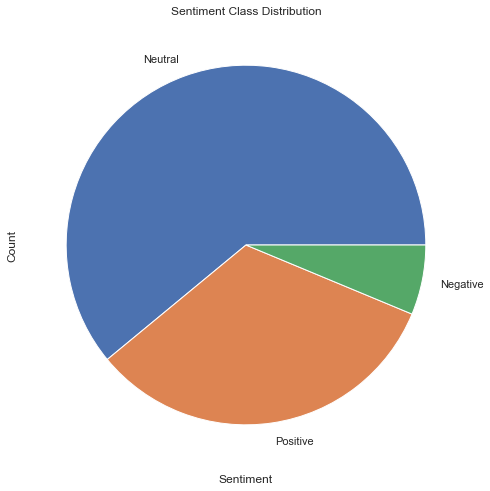

In [17]:
plt.figure()
sentiment_counts.plot(kind='pie')
plt.title("Sentiment Class Distribution")
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.show()

3.Does tweet length determine sentiment?

In [18]:
Movie_df['Char_length'] = Movie_df['Tweet'].str.len()
Movie_df['Word_count'] = Movie_df['Tweet'].str.split().str.len()

Movie_df.head()


,Tweet,Item,Sentiment,Char_length,Word_count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,127,23
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,139,22
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,79,15
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,82,15
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,131,17


In [19]:
Movie_df.groupby('Sentiment')[['Char_length', 'Word_count']].mean()


,Char_length,Word_count
Sentiment,,
Negative,109.414763,18.746924
Neutral,104.184054,17.444404
Positive,105.550505,18.176768


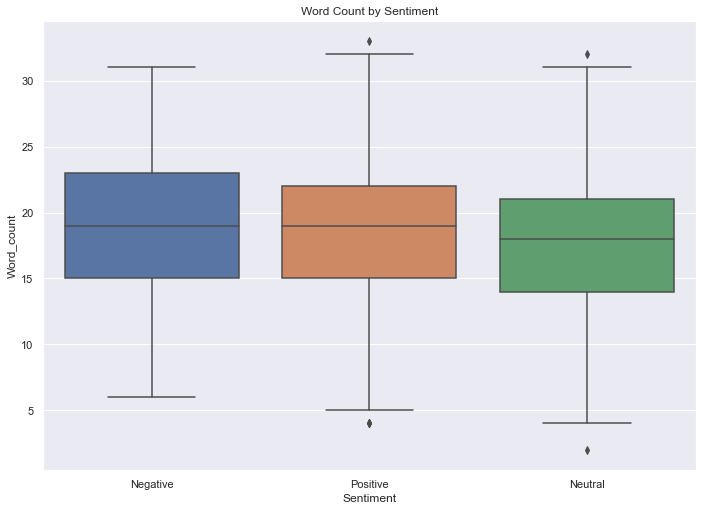

In [20]:
plt.figure()
sns.boxplot(x='Sentiment', y='Word_count', data=Movie_df)
plt.title("Word Count by Sentiment")
plt.show()


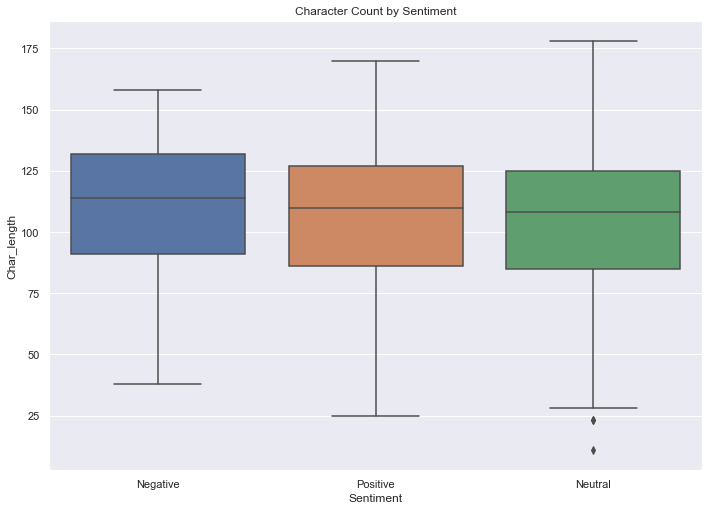

In [21]:
plt.figure()
sns.boxplot(x='Sentiment', y='Char_length', data=Movie_df)
plt.title("Character Count by Sentiment")
plt.show()

The results show that median tweet lengths are similar across sentiments, with heavily overlapping interquartile ranges. Although negative tweets are marginally longer, the difference is small and inconsistent, indicating that tweet length alone does not distinguish sentiment.

Likewise, neutral tweets tend to have slightly lower word counts, but this pattern is unreliable. Outliers appear across all classes, showing that extreme word counts occur regardless of sentiment.

4.What makes tweets positive vs negative? (Vocabulary use)

In [22]:
positive_tweets = Movie_df[Movie_df['Sentiment'] == 'positive']['Tweet']
negative_tweets = Movie_df[Movie_df['Sentiment'] == 'negative']['Tweet']


Most common words in positive tweets

In [23]:
#cv_pos = CountVectorizer(stop_words='english', max_features=20)
#pos_words = cv_pos.fit_transform(positive_tweets)

#pd.Series(cv_pos.get_feature_names_out()).value_counts()


5.Feature–target relationship (correlation & linearity)

In [32]:
#Dropped the columns that were created for Analysis

Movie_df=Movie_df.drop(['Char_length','Word_count'],axis=1)

DATA PROCESSING

Preprocessing 

The steps include:

- Normalization: Involves converting the text data into a consistent format by converting all the text data to lowercase.

- Cleaning: Removes URLs, @mentions and hashtags if any appear in the dataset. It expands contractions, normalizes repeated letters and strips special characters. In addition, it standardizes punctuation and whitespace.

- Tokenization: This involves breaking the texts into smaller words or phrases that the model can understand.

- Stopword Removal: This involves removing words with no significant meaning.

- POS Tagging: It is short for Part of Speech and involves assigning each text to a grammatical category like Noun, Verb and Adjective.

- Lemmatization: It reduces words to their base root or form.

In [33]:
# function to lowercase text
def to_lowercase(text):
    return text.lower()

Movie_df['Tweet']=Movie_df['Tweet'].apply(to_lowercase)
Movie_df.head()

,Tweet,Item,Sentiment
0,wesley83 3g iphone 3 hr tweeting riseaustin de...,iPhone,Negative
1,jessedee know fludapp awesome ipadiphone app y...,iPad or iPhone App,Positive
2,swonderlin wait ipad 2 sale sxsw,iPad,Positive
3,sxsw hope year festival isnt crashy year iphon...,iPad or iPhone App,Negative
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,Positive


Cleaning

In [34]:
#removing punctuation
import string

def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

Movie_df['Tweet']=Movie_df['Tweet'].apply(remove_punctuation)
Movie_df.head(5)

,Tweet,Item,Sentiment
0,wesley83 3g iphone 3 hr tweeting riseaustin de...,iPhone,Negative
1,jessedee know fludapp awesome ipadiphone app y...,iPad or iPhone App,Positive
2,swonderlin wait ipad 2 sale sxsw,iPad,Positive
3,sxsw hope year festival isnt crashy year iphon...,iPad or iPhone App,Negative
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,Positive


DOING AWAY WITH STOPWORDS

In [35]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def remove_stopword(text):
    return " ".join([word for word in text.split() if word not in 
                     ENGLISH_STOP_WORDS])


Movie_df['Tweet']=Movie_df['Tweet'].apply(remove_stopword)
Movie_df.head(10)

,Tweet,Item,Sentiment
0,wesley83 3g iphone 3 hr tweeting riseaustin de...,iPhone,Negative
1,jessedee know fludapp awesome ipadiphone app y...,iPad or iPhone App,Positive
2,swonderlin wait ipad 2 sale sxsw,iPad,Positive
3,sxsw hope year festival isnt crashy year iphon...,iPad or iPhone App,Negative
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,Positive
5,teachntech00 new ipad apps speechtherapy commu...,Unknown,Neutral
7,sxsw just starting ctia corner googleio hop sk...,Android,Positive
8,beautifully smart simple idea rt madebymany th...,iPad or iPhone App,Positive
9,counting day sxsw plus strong canadian dollar ...,Apple,Positive
10,excited meet samsungmobileus sxsw sprint galax...,Android,Positive


LEMMATIZATION

In [36]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # optional, needed for better lemmatization with multiple languages


[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [37]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pandas as pd

lemmatizer = WordNetLemmatizer()

def lemmatization_of_text(text):
    if pd.isna(text):
        return text
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmatized)


In [38]:
Movie_df['Tweet'] = Movie_df['Tweet'].apply(lemmatization_of_text)
Movie_df.head(10)


,Tweet,Item,Sentiment
0,wesley83 3g iphone 3 hr tweeting riseaustin de...,iPhone,Negative
1,jessedee know fludapp awesome ipadiphone app y...,iPad or iPhone App,Positive
2,swonderlin wait ipad 2 sale sxsw,iPad,Positive
3,sxsw hope year festival isnt crashy year iphon...,iPad or iPhone App,Negative
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,Positive
5,teachntech00 new ipad apps speechtherapy commu...,Unknown,Neutral
7,sxsw just starting ctia corner googleio hop sk...,Android,Positive
8,beautifully smart simple idea rt madebymany th...,iPad or iPhone App,Positive
9,counting day sxsw plus strong canadian dollar ...,Apple,Positive
10,excited meet samsungmobileus sxsw sprint galax...,Android,Positive


In [39]:
tokenizer = RegexpTokenizer(r"[a-zA-Z]+(?:'[a-z]+)?")

In [40]:
Movie_df.head(10)

,Tweet,Item,Sentiment
0,wesley83 3g iphone 3 hr tweeting riseaustin de...,iPhone,Negative
1,jessedee know fludapp awesome ipadiphone app y...,iPad or iPhone App,Positive
2,swonderlin wait ipad 2 sale sxsw,iPad,Positive
3,sxsw hope year festival isnt crashy year iphon...,iPad or iPhone App,Negative
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,Positive
5,teachntech00 new ipad apps speechtherapy commu...,Unknown,Neutral
7,sxsw just starting ctia corner googleio hop sk...,Android,Positive
8,beautifully smart simple idea rt madebymany th...,iPad or iPhone App,Positive
9,counting day sxsw plus strong canadian dollar ...,Apple,Positive
10,excited meet samsungmobileus sxsw sprint galax...,Android,Positive


In [41]:
def get_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,  #Represents an Adjective
        'N': wordnet.NOUN, #Represents a Noun
        'V': wordnet.VERB, #Represents a Verb
        'R': wordnet.ADV   #Represents an Adverb
    }
    return tag_dict.get(tag, wordnet.NOUN)

In [43]:
CleanMovie_df= Movie_df[['Tweet', 'Sentiment']]
CleanMovie_df

,Tweet,Sentiment
0,wesley83 3g iphone 3 hr tweeting riseaustin de...,Negative
1,jessedee know fludapp awesome ipadiphone app y...,Positive
2,swonderlin wait ipad 2 sale sxsw,Positive
3,sxsw hope year festival isnt crashy year iphon...,Negative
4,sxtxstate great stuff fri sxsw marissa mayer g...,Positive
...,...,...
9088,ipad sxsw link,Positive
9089,wave buzz rt mention interrupt regularly sched...,Neutral
9090,google zeiger physician reported potential ae ...,Neutral
9091,verizon iphone customer complained time fell h...,Neutral


MODELLING

In [45]:
label_encoder = LabelEncoder()
CleanMovie_df['Target'] = label_encoder.fit_transform(CleanMovie_df['Sentiment'])
CleanMovie_df.head()

,Tweet,Sentiment,Target
0,wesley83 3g iphone 3 hr tweeting riseaustin de...,Negative,0
1,jessedee know fludapp awesome ipadiphone app y...,Positive,2
2,swonderlin wait ipad 2 sale sxsw,Positive,2
3,sxsw hope year festival isnt crashy year iphon...,Negative,0
4,sxtxstate great stuff fri sxsw marissa mayer g...,Positive,2


In [46]:
CleanMovie_df['Target'].value_counts()

Target
1    5531
2    2970
0     569
Name: count, dtype: int64

In [47]:
X = CleanMovie_df['Tweet']
y = CleanMovie_df['Target']

In [48]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)
